# Лабораторная работа 8. Факторный анализ
### Кирилл Захаров
2023

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
%matplotlib inline

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from scipy.stats import multivariate_normal
import scipy.stats as sts
import shap

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

plt.style.use('ggplot')

Возьмем набор данных магазина 'Walmart'. Бубем прогнозировать цену на бензин 'Fuel_Price'.

In [42]:
data = pd.read_csv('Walmart.csv')

In [43]:
data['Date'] = pd.to_datetime(data['Date'], format='mixed')

Выделим новые признаки, соответсвующие дате.

In [44]:
data['day'] = data['Date'].dt.day
data['month'] = data['Date'].dt.month
data['year'] = data['Date'].dt.year
data = data.drop(['Date'], axis=1)

In [45]:
data

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,day,month,year
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,2,5,2010
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,2,12,2010
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,19,2,2010
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,26,2,2010
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,3,5,2010
...,...,...,...,...,...,...,...,...,...,...
6430,45,713173.95,0,64.88,3.997,192.013558,8.684,28,9,2012
6431,45,733455.07,0,64.89,3.985,192.170412,8.667,10,5,2012
6432,45,734464.36,0,54.47,4.000,192.327265,8.667,10,12,2012
6433,45,718125.53,0,56.47,3.969,192.330854,8.667,19,10,2012


Посмотрим матрицу корреляций.

The figure layout has changed to tight


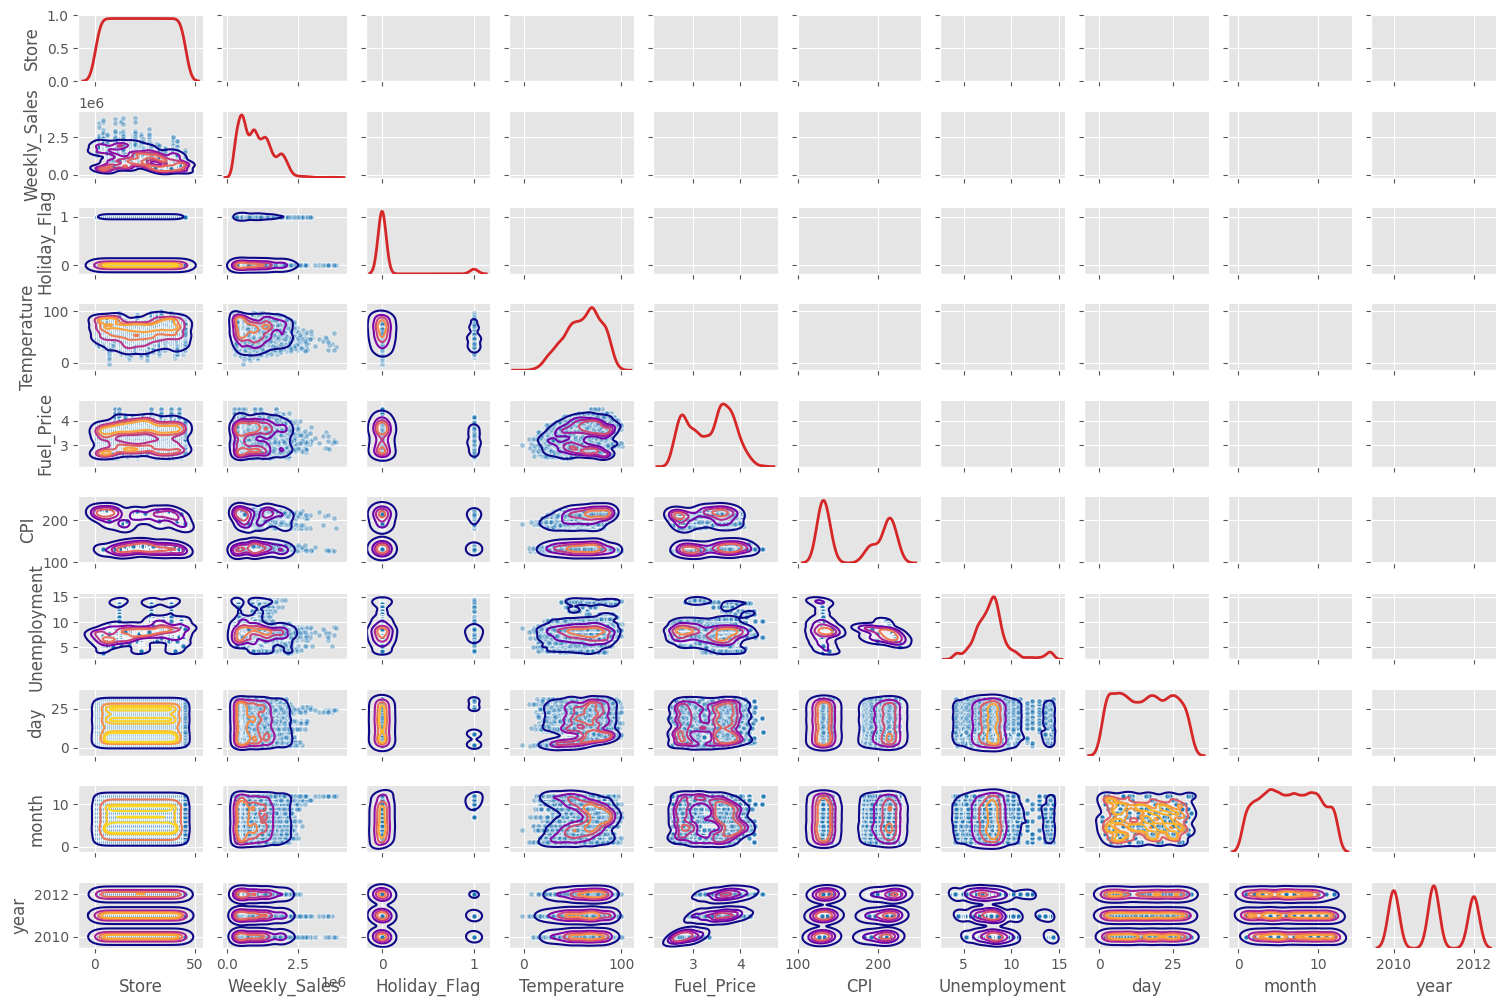

In [46]:
def snsPairGrid(df):
    g = sns.PairGrid(df, diag_sharey=False)
    g.fig.set_size_inches(15,10)
    
    g.map_diag(sns.kdeplot, lw=2, color='tab:red')
    g.map_lower(sns.scatterplot, s=15, color="tab:blue", linewidth=1, alpha=0.4)
    g.map_lower(sns.kdeplot, cmap='plasma', n_levels=5)
    plt.tight_layout(pad=0.5)
    

snsPairGrid(data)

Все признаки не особо коррелируют между собой. А цена которую будем предсказывать коррелирует с годом, поэтому этот признак должен быть значим при прогнозе.

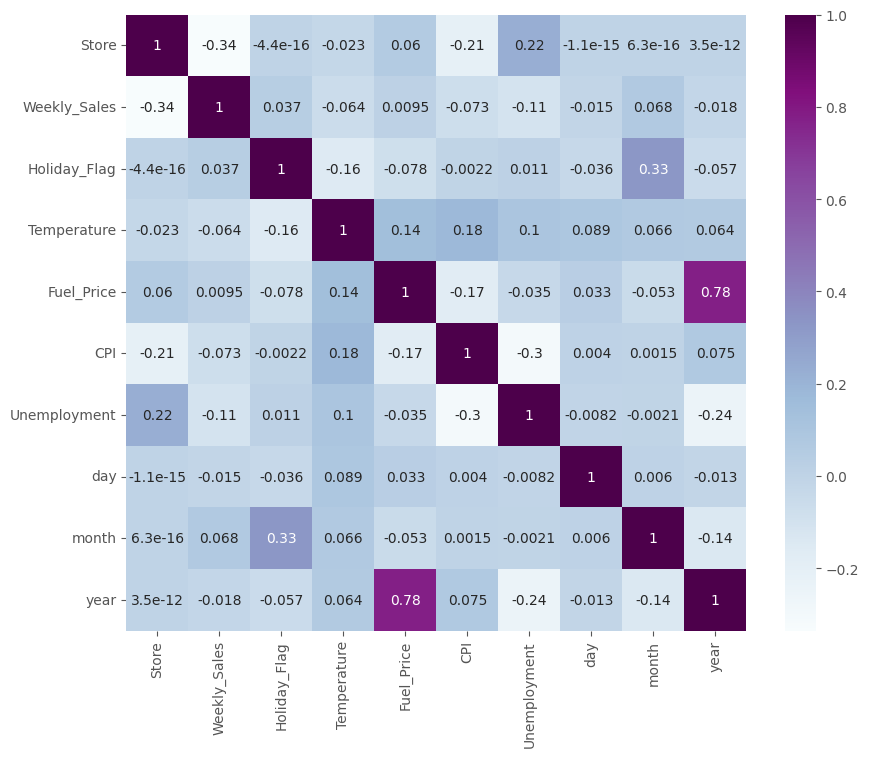

In [47]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='BuPu')

plt.show()

Посмотрим годится ли данный датасет для факторного анализа. Как видно значения критерия низкое, поэтому подходит не особо, но посмотрим на разницу в качестве прогноза.

In [48]:
chi_square_value, p_value = calculate_bartlett_sphericity(data)
kmo_all, kmo_model = calculate_kmo(data[np.setdiff1d(data.columns, 'Fuel_Price')])
print('Бартлетт хи-квадрат: %.1f c p=%.2f; КМО: %.3f'% (chi_square_value, p_value, kmo_model))

Бартлетт хи-квадрат: 11729.4 c p=0.00; КМО: 0.472


Выберем методом LLO количество признаков, которое необходимо оставить. Для этого возьмем те, у которых собственные числа больше 1, то есть дисперсия не затухает.

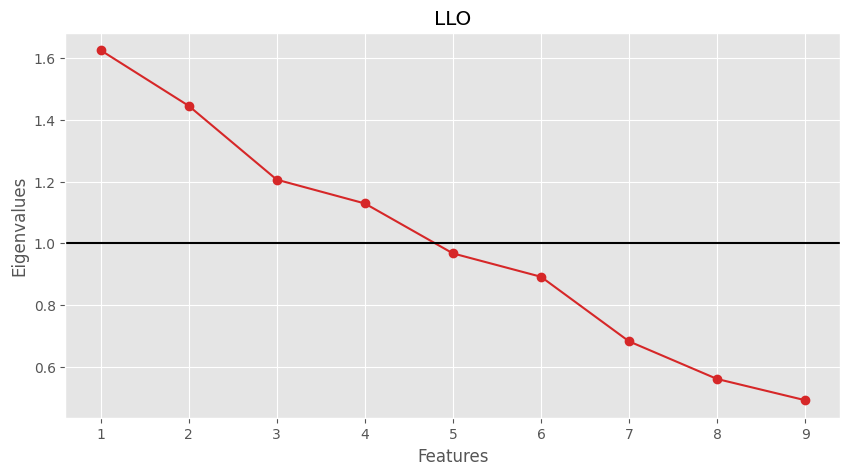

In [49]:
fa = FactorAnalyzer()
fa.fit(data[np.setdiff1d(data.columns, 'Fuel_Price')])
ev, v = fa.get_eigenvalues()

plt.subplots(figsize=(10, 5), dpi=100)
plt.plot(range(1, data.shape[1]), ev, marker='o', color='tab:red')

plt.title('LLO')

plt.xlabel('Features')
plt.ylabel('Eigenvalues')
plt.axhline(y=1, c='black')
plt.show()

Отобрали 4 фактора, теперь понизим размерность.

In [50]:
fa = FactorAnalyzer()
fa.set_params(n_factors=4, rotation='varimax')

fa.fit(data[np.setdiff1d(data.columns, 'Fuel_Price')])
loadings = fa.loadings_
loadings = np.abs(loadings)

df_fa = pd.DataFrame(loadings, columns=['f%i'%i for i in range(1, loadings.shape[1]+1)])
df_fa['feature'] = np.setdiff1d(data.columns, 'Fuel_Price')

In [51]:
df_fa

,f1,f2,f3,f4,feature
0,0.316324,0.124732,0.004819,0.208887,CPI
1,0.045052,0.032863,0.350780,0.145869,Holiday_Flag
2,0.116506,0.989747,0.042696,0.080682,Store
3,0.020557,0.042731,0.049654,0.847404,Temperature
4,0.978584,0.133984,0.068787,0.130142,Unemployment
5,0.015918,0.336487,0.065205,0.086327,Weekly_Sales
6,0.012056,0.011225,0.009262,0.098956,day
7,0.058125,0.038684,0.986512,0.135542,month
8,0.263174,0.040404,0.127221,0.049117,year


По таблице видно, что использование 4 факторов оказалось не плохим, все 4 признака покрывают взаимосвязи на хорошем уровне.

<Axes: ylabel='feature'>

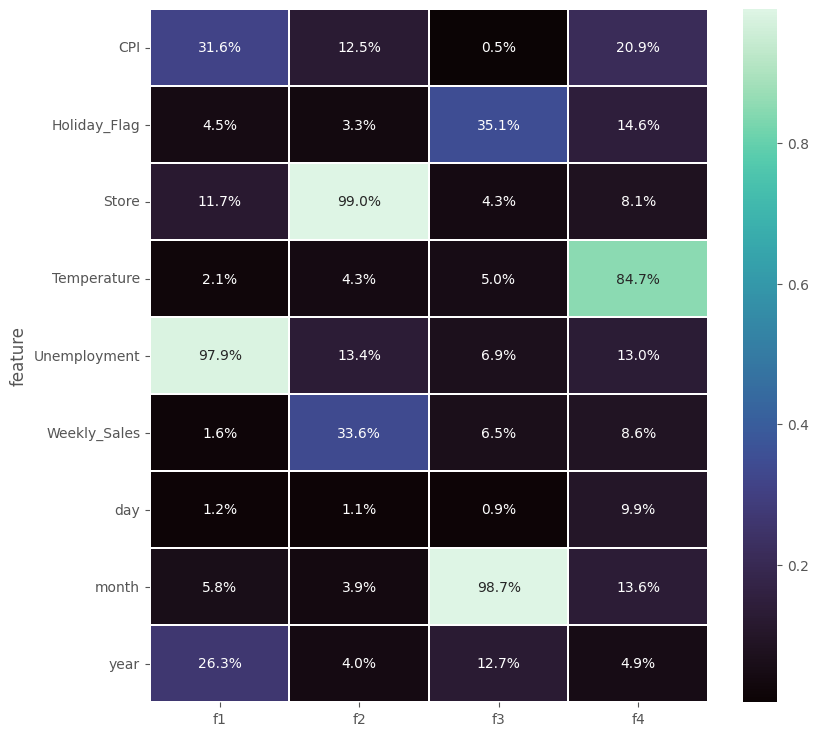

In [52]:
df_fa_pivot = (df_fa.pivot_table(index='feature'))
plt.figure(figsize=(9,9))
sns.heatmap(df_fa_pivot, annot=True, fmt='.1%', linewidths=0.1, cmap='mako')

In [53]:
Xft = fa.transform(data[np.setdiff1d(data.columns, 'Fuel_Price')])

In [54]:
Xft.shape

(6435, 4)

In [55]:
X = Xft
y = data['Fuel_Price']

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

Сделаем подбор параметров для XGBoost.

In [112]:
params = {'n_estimators': [50, 100], 'max_depth': [3, 4, 5]}

gscv = GridSearchCV(XGBRegressor(), param_grid=params)

In [113]:
gscv.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'max_depth': [3, 4, 5], 'n_estimators': [50, 100]})

In [114]:
gscv.best_params_

{'max_depth': 5, 'n_estimators': 100}

In [115]:
model = gscv.best_estimator_

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Процентная ошибка всего 1%.

In [116]:
mean_absolute_percentage_error(y_test, model.predict(X_test))

0.011586509826640556

Доля объясненной дисперсии близка к 1, а значит модель хорошо справилась с прогнозированием.

In [117]:
r2_score(y_test, model.predict(X_test))

0.9856715366531641

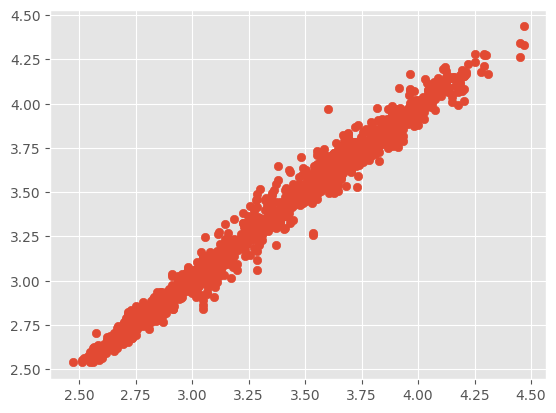

In [118]:
plt.scatter(y_test, model.predict(X_test))
plt.show()

Теперь посмотрим на значимость признаков для исходной модели без понижения размерности.

In [119]:
model = XGBRegressor(n_estimators = 100, max_depth=5)

In [120]:
X = data[np.setdiff1d(data.columns, 'Fuel_Price')]
y = data['Fuel_Price']

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [122]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [123]:
r2_score(model.predict(X_test), y_test)

0.9866843744951214

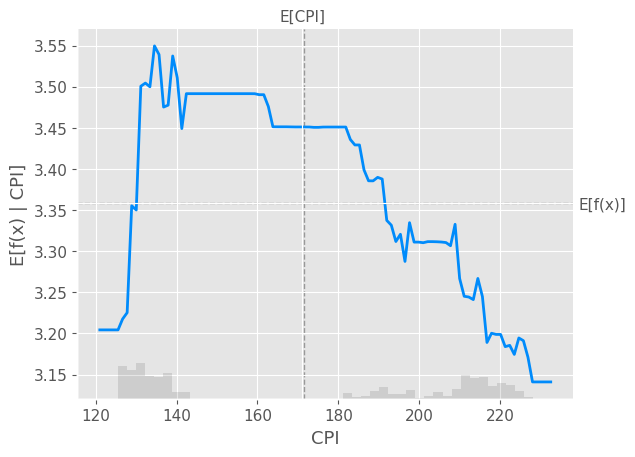

In [124]:
shap.partial_dependence_plot(
    "CPI", model.predict, X, ice=False,
    model_expected_value=True, feature_expected_value=True
)

In [112]:
explainer = shap.Explainer(model.predict, X)
shap_values = explainer(X)

ExactExplainer explainer: 6436it [01:36, 59.33it/s]                          


Как и ожидалось, наиболее значимым оказался год. При низких значениях года, модель занижает цены, а при высоких наоборот увеличивает. Для признака флаг празника видно, что во время праздников цена на бензин завышается. День недели показывает, что по выходным цена калеблется меньше, в начале же недели цена скачет. Есть также заметное влияние индекса потребительских цен: при высоких значениях цена на бензин снижается, а при низких растет. 

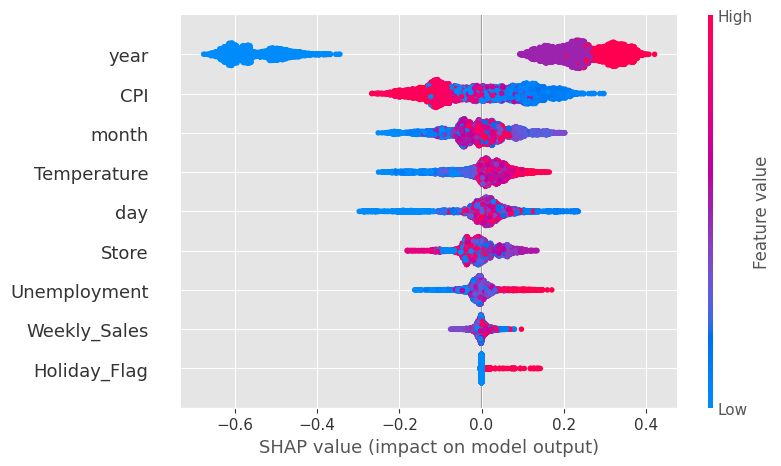

In [113]:
shap.plots.beeswarm(shap_values)

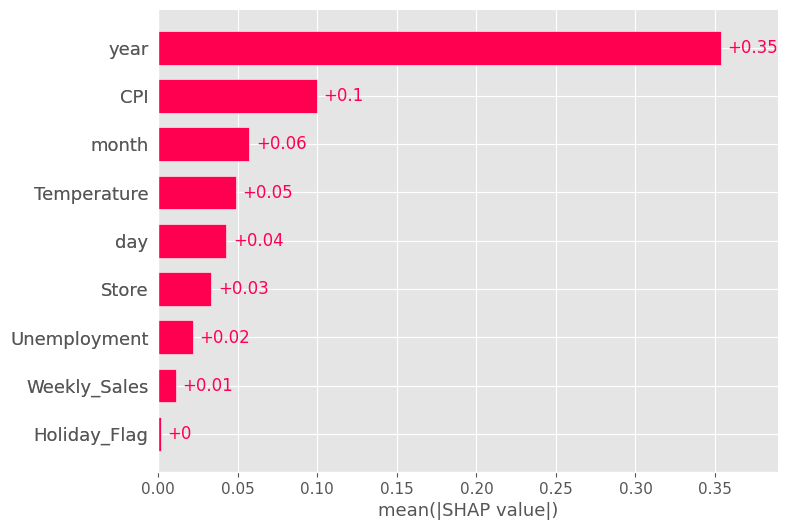

In [114]:
shap.plots.bar(shap_values)

Можно отобразить значимость признаков из модели XGBoost, здесб картина будет другая, так как shap прогоняет алгоритм на деревьях по многу комбинаций.

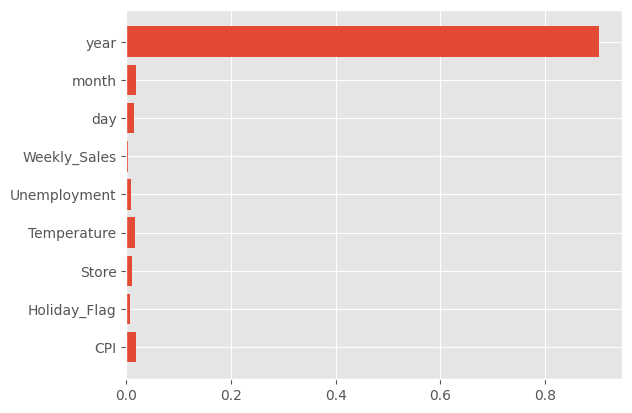

In [121]:
plt.barh(X.columns, model.feature_importances_)
plt.show()